In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import matplotlib
import logging

import utils as utils
from matplotlib import cm

In [2]:
runname = 'debug_withC_rogers_netcdfBdy1_EB_soliton_f_withsponge_focus_finey_summer'
datafilepath = '/Volumes/Tan_2023/projects_backup/SUNTANS/HPC/'+runname+'/data/'

# datafilename = 'sun_out.nc_0000.nc'
datafilename = 'sun_sparse.nc_0000.nc'

# path to saved result
resultfilepath = datafilepath[:-5] + 'mfiles/results/'
# path to saved figures
outfilepath = '../figure/'
if not os.path.exists(resultfilepath):
    os.mkdir(resultfilepath)
if not os.path.exists(outfilepath):
    os.mkdir(outfilepath)

param_data = {
    "datafilepath": datafilepath,
    "netcdf_filename": datafilename,
            }
param_result = {
    "resultfilepath": resultfilepath,
    "result_filename": 'sun_out_energy_derived.nc',
            }
idx_end = -15

# Read data

In [3]:
data = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'])
data_bt = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bt.nc')
data_bc = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bc.nc')

# Island center & Shoaling depth

In [4]:
lambdaM2=70.1e3
l_sponge = 20e3
L=1.5*lambdaM2+2*l_sponge
W=1.5*lambdaM2

x_c = 2*l_sponge+1.5*lambdaM2/2
y_c = W/2

In [5]:
depth_top = 4
depth_shoal = 180
depth_bottom = 600-1e-2

In [6]:
data

<xarray.Dataset> Size: 29GB
Dimensions:       (time: 171, x: 1814, y: 1314, z: 100)
Coordinates:
  * x             (x) float64 15kB 40.01 212.6 385.0 ... 1.45e+05 1.451e+05
  * y             (y) float64 11kB 40.01 180.1 319.9 ... 1.05e+05 1.051e+05
  * z             (z) float64 800B -1.311 -3.973 -6.674 ... -576.0 -587.2 -598.7
  * time          (time) datetime64[ns] 1kB 2013-01-01T12:00:08 ... 2013-01-0...
Data variables:
    dEp0          (time, x, y) float64 3GB ...
    dEp_prime     (time, x, y) float64 3GB ...
    dEk0          (time, x, y) float64 3GB ...
    dEk_prime     (time, x, y) float64 3GB ...
    C_int         (time, x, y) float64 3GB ...
    D0            (time, x, y) float64 3GB ...
    D_prime       (time, x, y) float64 3GB ...
    depth         (x, y) float64 19MB ...
    dissip0       (time, x, y) float64 3GB ...
    dissip_prime  (time, x, y) float64 3GB ...
Attributes:
    title:    SUNTANS internally calculated energy budget

# Dissipation contributers

In [7]:
# change to radial coordinate
dis_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        dis_c[i,j] = np.sqrt((data.x[i].data-x_c)**2+(data.y[j].data-y_c)**2)
        
theta_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        theta_c[i,j] = np.arctan2(data.y[j].data-y_c, data.x[i].data-x_c)

In [8]:
dis_top = np.mean(np.where((data.depth>=depth_top-.5) & (data.depth.data<=depth_top+.5)))
dis_shoal = np.mean(dis_c[np.where((data.depth>=depth_shoal-1) & (data.depth.data<=depth_shoal+1))])
dis_bottom = np.mean(dis_c[np.where((data.depth>=depth_bottom-1) & (data.depth.data<depth_bottom))])
quadrants_info = {
    "r_quad": np.array([dis_shoal,dis_bottom]),
    "quadrants": ['east', 'north', 'west', 'south'],
    "theta_quad": [[-45, 45], [45, 135], [135, -135], [-135, -45]]
            }

In [9]:
# integrate flux divergence within inner and outer circles divided by shoaling depth
mask_ring_inner = (dis_c>=dis_top) & (dis_c<quadrants_info["r_quad"][0])
mask_ring_outter = (dis_c>=quadrants_info["r_quad"][0]) & (dis_c<quadrants_info["r_quad"][-1])

## dissipation

In [10]:
dissip0 = data.dissip0
dissip_prime = data.dissip_prime

In [11]:
# barotropic
var = dissip0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dissip0_inner = var.integrate('y')*1e-6
var = dissip0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dissip0_outter = var.integrate('y')*1e-6

# baroclinic
var = dissip_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dissip_prime_inner = var.integrate('y')*1e-6
var = dissip_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dissip_prime_outter = var.integrate('y')*1e-6

dissip0_inner = dissip0_inner.data
dissip0_outter = dissip0_outter.data
dissip_prime_inner = dissip_prime_inner.data
dissip_prime_outter = dissip_prime_outter.data

## energy time derivative

In [12]:
# barotropic
var = data.dEp0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEp0_inner = var.integrate('y')*1e-6
var = data.dEp0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEp0_outter = var.integrate('y')*1e-6
var = data.dEk0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEk0_inner = var.integrate('y')*1e-6
var = data.dEk0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEk0_outter = var.integrate('y')*1e-6

# baroclinic
var = data.dEp_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEp_prime_inner = var.integrate('y')*1e-6
var = data.dEp_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEp_prime_outter = var.integrate('y')*1e-6
var = data.dEk_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEk_prime_inner = var.integrate('y')*1e-6
var = data.dEk_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
dEk_prime_outter = var.integrate('y')*1e-6

dEp0_inner = dEp0_inner.data
dEp0_outter = dEp0_outter.data
dEk0_inner = dEk0_inner.data
dEk0_outter = dEk0_outter.data
dEp_prime_inner = dEp_prime_inner.data
dEp_prime_outter = dEp_prime_outter.data
dEk_prime_inner = dEk_prime_inner.data
dEk_prime_outter = dEk_prime_outter.data

## fluxes

In [13]:
# barotropic
div_F0_inner = np.zeros((4, len(data.time)))
div_F0_outter = np.zeros((4, len(data.time)))

for var_num in np.arange(1,5):
    # var = eval(f'data_bt.div_F0{var_num}.differentiate("time",datetime_unit="s").copy()')
    var = eval(f'data_bt.div_F0{var_num}.copy()')
    for i in range(len(data.time)):
        var_ = var[i,:,:].data.copy()
        var_[~mask_ring_inner] = 0
        var[i,:,:] = var_
    var = var.integrate('x')
    div_F0_inner[var_num-1,:] = var.integrate('y')*1e-6
    
for var_num in np.arange(1,5):
    # var = eval(f'data_bt.div_F0{var_num}.differentiate("time",datetime_unit="s").copy()')
    var = eval(f'data_bt.div_F0{var_num}.copy()')
    for i in range(len(data.time)):
        var_ = var[i,:,:].data.copy()
        var_[~mask_ring_outter] = 0
        var[i,:,:] = var_
    var = var.integrate('x')
    div_F0_outter[var_num-1,:] = var.integrate('y')*1e-6

# baroclinic
div_Fprime_inner = np.zeros((5, len(data.time)))
div_Fprime_outter = np.zeros((5, len(data.time)))

for var_num in np.arange(1,6):
    var = eval(f'data_bc.div_Fprime{var_num}.copy()')
    for i in range(len(data.time)):
        var_ = var[i,:,:].data.copy()
        var_[~mask_ring_inner] = 0
        var[i,:,:] = var_
    var = var.integrate('x')
    div_Fprime_inner[var_num-1,:] = var.integrate('y')*1e-6
    
for var_num in np.arange(1,6):
    var = eval(f'data_bc.div_Fprime{var_num}.copy()')
    for i in range(len(data.time)):
        var_ = var[i,:,:].data.copy()
        var_[~mask_ring_outter] = 0
        var[i,:,:] = var_
    var = var.integrate('x')
    div_Fprime_outter[var_num-1,:] = var.integrate('y')*1e-6

## bottom drag

In [14]:
# barotropic
var = data.D0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
D0_inner = var.integrate('y')*1e-6
var = data.D0.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
D0_outter = var.integrate('y')*1e-6
# baroclinic
var = data.D_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
D_prime_inner = var.integrate('y')*1e-6
var = data.D_prime.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
D_prime_outter = var.integrate('y')*1e-6

D0_inner = D0_inner.data
D0_outter = D0_outter.data
D_prime_inner = D_prime_inner.data
D_prime_outter = D_prime_outter.data

## conversion

In [15]:
var = data.C_int.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_inner] = 0
    var[i,:,:] = var_
var = var.integrate('x')
C_inner = var.integrate('y')*1e-6
var = data.C_int.copy()
for i in range(len(data.time)):
    var_ = var[i,:,:].data.copy()
    var_[~mask_ring_outter] = 0
    var[i,:,:] = var_
var = var.integrate('x')
C_outter = var.integrate('y')*1e-6

C_inner = C_inner.data
C_outter = C_outter.data

# making plot

In [43]:
var0_name = [r"$-\Delta\langle E_{k0}\rangle$", 
             r"$-\Delta\langle E_{p0}\rangle$",
             r"$-\nabla\cdot\int\mathbf{U}_H\langle E_{k0}\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{U}_HH\rho_0g\eta$dt",
             r"$-\nabla\cdot\int\mathbf{U}_H\langle p'\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{U}_Hq$dt",
             r"$-\int\langle C\rangle$dt", 
             r"$-\int D_0$dt", 
             r"$\int\epsilon_0$dt"
            ]
var_prime_name = [r"$-\Delta\langle E_k'\rangle$", 
             r"$-\Delta\langle E_p'\rangle$",
             r"$-\nabla\cdot\int\mathbf{u_H}\langle E_k'\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{u_H}\langle E_{k0}'\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{u_H}\langle E_p'\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{u_H'}\langle p'\rangle$dt",
             r"$-\nabla\cdot\int\mathbf{u_H'}q$dt",
             r"$\int\langle C\rangle$dt",
             r"$-\int D'$dt", 
             r"$\int\epsilon'$dt"
            ]

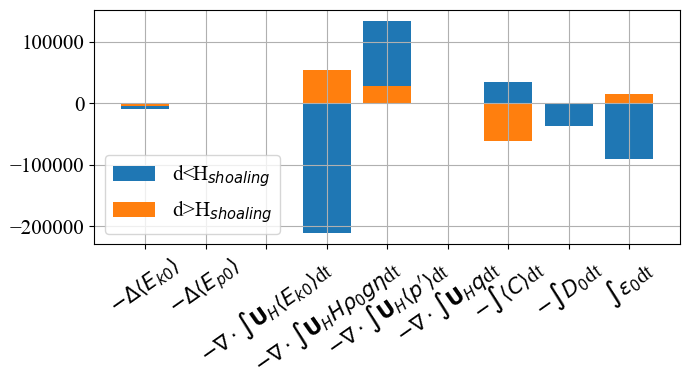

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

ax.bar(var0_name, np.hstack([-dEk0_inner[-1], -dEp0_inner[-1], -div_F0_inner[:,-1], -C_inner[-1], -D0_inner[-1], dissip0_inner[-1]]), label='d<H$_{shoaling}$')
ax.bar(var0_name, np.hstack([-dEk0_outter[-1], -dEp0_outter[-1], -div_F0_outter[:,-1], -C_outter[-1], -D0_outter[-1], dissip0_outter[-1]]), label='d>H$_{shoaling}$')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 35)
ax.grid()
ax.legend(fontsize=15, ncol=1, loc='lower left')
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dissp0_areaintegrate_contributer_summer_f.jpeg", dpi=300)

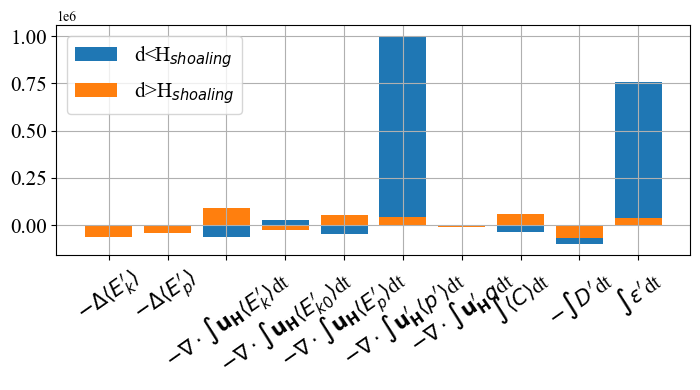

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

ax.bar(var_prime_name, np.hstack([-dEk_prime_inner[-1], -dEp_prime_inner[-1], -div_Fprime_inner[:,-1], C_inner[-1], -D_prime_inner[-1], dissip_prime_inner[-1]]), label='d<H$_{shoaling}$')
ax.bar(var_prime_name, np.hstack([-dEk_prime_outter[-1], -dEp_prime_outter[-1], -div_Fprime_outter[:,-1], C_outter[-1], -D_prime_outter[-1], dissip_prime_outter[-1]]), label='d>H$_{shoaling}$')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 35)
ax.grid()
ax.legend(fontsize=15, ncol=1, loc='upper left')
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"dissp_prime_areaintegrate_contributer_summer_f.jpeg", dpi=300)

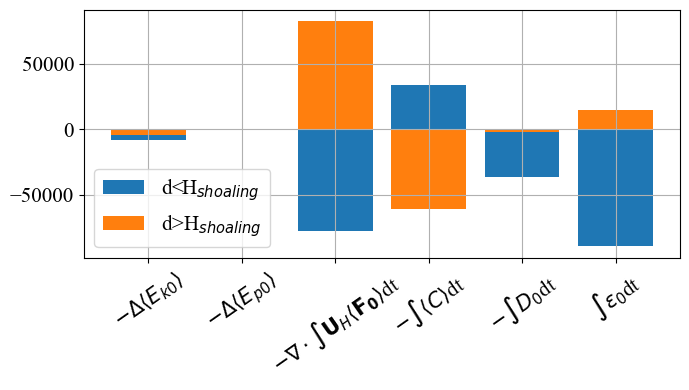

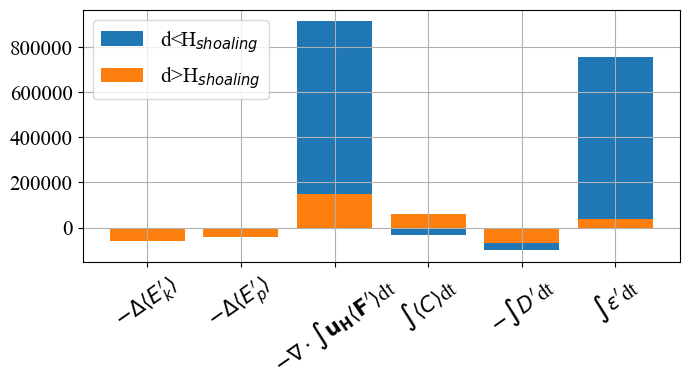

In [46]:
var0_name = [r"$-\Delta\langle E_{k0}\rangle$", 
             r"$-\Delta\langle E_{p0}\rangle$",
             r"$-\nabla\cdot\int\mathbf{U}_H\langle \mathbf{F_0}\rangle$dt",
             r"$-\int\langle C\rangle$dt", 
             r"$-\int D_0$dt", 
             r"$\int\epsilon_0$dt"
            ]
var_prime_name = [r"$-\Delta\langle E_k'\rangle$", 
             r"$-\Delta\langle E_p'\rangle$",
             r"$-\nabla\cdot\int\mathbf{u_H}\langle \mathbf{F'}\rangle$dt",
             r"$\int\langle C\rangle$dt",
             r"$-\int D'$dt", 
             r"$\int\epsilon'$dt"
            ]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
ax.bar(var0_name, np.hstack([-dEk0_inner[-1], -dEp0_inner[-1], np.sum(-div_F0_inner[:,-1]), -C_inner[-1], -D0_inner[-1], dissip0_inner[-1]]), label='d<H$_{shoaling}$')
ax.bar(var0_name, np.hstack([-dEk0_outter[-1], -dEp0_outter[-1], np.sum(-div_F0_outter[:,-1]), -C_outter[-1], -D0_outter[-1], dissip0_outter[-1]]), label='d>H$_{shoaling}$')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 35)
ax.grid()
ax.legend(fontsize=15, ncol=1, loc='lower left')
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()
plt.savefig(outfilepath+ f"dissp0_areaintegrate_contributer_combined_summer_f.jpeg", dpi=300)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4))
ax.bar(var_prime_name, np.hstack([-dEk_prime_inner[-1], -dEp_prime_inner[-1], np.sum(-div_Fprime_inner[:,-1]), C_inner[-1], -D_prime_inner[-1], dissip_prime_inner[-1]]), label='d<H$_{shoaling}$')
ax.bar(var_prime_name, np.hstack([-dEk_prime_outter[-1], -dEp_prime_outter[-1], np.sum(-div_Fprime_outter[:,-1]), C_outter[-1], -D_prime_outter[-1], dissip_prime_outter[-1]]), label='d>H$_{shoaling}$')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 35)
ax.grid()
ax.legend(fontsize=15, ncol=1, loc='upper left')
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()
plt.savefig(outfilepath+ f"dissp_prime_areaintegrate_contributer_combined_summer_f.jpeg", dpi=300)

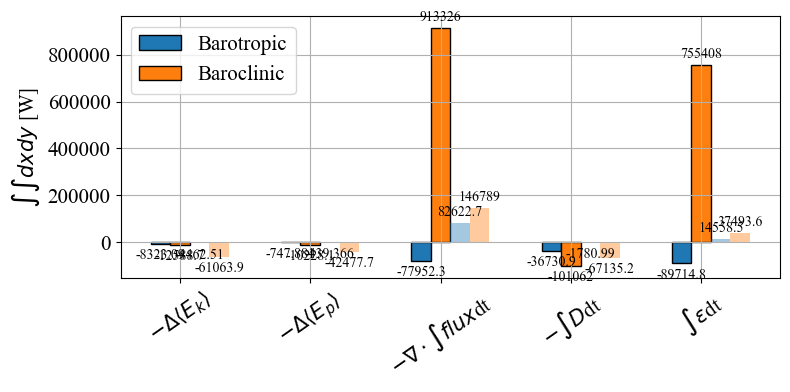

In [54]:
var_name  = (r"$-\Delta\langle E_k\rangle$", r"$-\Delta\langle E_p\rangle$", r"$-\nabla\cdot\int flux$dt", r"$-\int D$dt", r"$\int\epsilon$dt")
var_inner = {
    'Barotropic': (-dEk0_inner[-1], -dEp0_inner[-1], np.sum(-div_F0_inner[:,-1]), -D0_inner[-1], dissip0_inner[-1]),
    'Baroclinic': (-dEk_prime_inner[-1], -dEp_prime_inner[-1], np.sum(-div_Fprime_inner[:,-1]), -D_prime_inner[-1], dissip_prime_inner[-1]),
}
var_outter = {
    'Barotropic': (-dEk0_outter[-1], -dEp0_outter[-1], np.sum(-div_F0_outter[:,-1]), -D0_outter[-1], dissip0_outter[-1]),
    'Baroclinic': (-dEk_prime_outter[-1], -dEp_prime_outter[-1], np.sum(-div_Fprime_outter[:,-1]), -D_prime_outter[-1], dissip_prime_outter[-1]),
}

x = np.arange(len(var_name))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

colors = ['tab:blue','tab:orange']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

count = 0
for attribute, measurement in var_inner.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, 
                   color=colors[count], edgecolor='black')#, hatch="/")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    count+=1
    
count = 0
for attribute, measurement in var_outter.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, color=colors[count], alpha=.4)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    count+=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r"$\int\int dxdy$ [W]", fontsize=15)
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', rotation = 35)
ax.grid()
ax.legend(fontsize=15, ncol=1, loc='upper left')
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()
plt.savefig(outfilepath+ f"dissp_areaintegrate_contributer_combined_summer_f.jpeg", dpi=300)